In [27]:
using Images
using Interact
using Colors

In [28]:
download("http://upload.wikimedia.org/wikipedia/commons/2/25/Wfm_stata_center.jpg",  "Wfm_stata_center.jpg")


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  311k  100  311k    0     0   698k      0 --:--:-- --:--:-- --:--:--  698k


"Wfm_stata_center.jpg"

In [29]:
function brightness(I)
    w,h = size(I)
    b = fill(0f0, w+2, h+2)

    @inbounds for x=1:w
        @simd for y=1:h
            b[x+1,y+1] = I[x,y].r + I[x,y].g + I[x,y].b
        end
    end
    b
end

brightness (generic function with 1 method)

In [30]:
function energy(b,w)
    tmp,h = size(b) # takes in a brightness image, which is padded with zeros around border
    
    e = fill(Inf32,w,h-2)
    
    for x=2:w-1
        for y=2:h-1
            
            @inbounds xe = (b[x-1,y-1] + 2*b[x-1,y] + b[x-1,y+1]) - (b[x+1,y-1] + 2*b[x+1,y] + b[x+1,y+1])
            @inbounds ye = (b[x-1,y-1] + 2*b[x,y-1] + b[x+1,y-1]) - (b[x-1,y+1] + 2*b[x,y+1] + b[x+1,y+1])
            @inbounds e[x,y-1] = sqrt(xe^2 + ye^2)
        end
    end
    
    return e
end

energy (generic function with 1 method)

In [31]:
function get_seam(e)
    w,h = size(e) #energy size is w+2, due to Inf32 padding
    
    #cum_e = copy(e)
    
    seam = fill(Int64(0),1,h)
    
    #compute cumulative energy, bottom to top
    for y=h-1:-1:1
        for x = 2:w-1
            @inbounds e[x,y] += min(e[x-1,y+1], min(e[x,y+1],e[x+1,y+1]) )
        end
    end
    
    #trace path down to get seam
    tmp, x = findmin(e[:,1])
    seam[1] = x
    for y = 1:h-1
        @inbounds tmpL = (e[x-1,y+1], -1)
        @inbounds tmpD = (e[x,y+1], 0)
        @inbounds tmpR = (e[x+1,y+1], 1)
        tmp,dir = min( tmpL, min(tmpD, tmpR) )
         x += dir
        @inbounds seam[y+1] = x
    end
    
    return seam
end

get_seam (generic function with 1 method)

In [32]:
function carve_seam!(b, imgdat, seam, w)
    #will take width as an argument, to prevent need for copying later
    tmp,h = size(imgdat)
    for y = 1:h
        for x=seam[y]:w-1
            @inbounds b[x,y] = b[x+1,y]
            @inbounds imgdat[x,y] = imgdat[x+1,y]
        end
        @inbounds b[w,y]=0
    end
    
end

carve_seam! (generic function with 1 method)

In [33]:
# The actual function that does the work
function carve_image(img, Nseams)
    img_array = []
    imdat = data(img)
    #get original image dimensions
    w,h = size(imdat)

    b = brightness(imdat)
    
    for n = 1:Nseams
        
        if(n%5==0)
            print("$(n) ")
        end
        e = energy(b,w-n+1)
        s = get_seam(e)
        carve_seam!(b,imdat,s,w-n)
        push!(img_array, copyproperties(img,imdat[1:w-n, 1:h]))
    end
    
    img_array
end

carve_image (generic function with 1 method)

In [34]:
function carve_images(img)
    carve_image(img,width(img)-1)
end

carve_images (generic function with 1 method)

In [35]:
img = imread("Wfm_stata_center.jpg")
gc_enable(false)
@time A = carve_images(img);
gc_enable(true)



5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 95 100 105 110 115 120 125 130 135 140 145 150 155 160 165 170 175 180 185 190 195 200 205 210 215 220 225 230 235 240 245 250 255 260 265 270 275 280 285 290 295 300 305 310 315 320 325 330 335 340 345 350 355 360 365 370 375 380 385 390 395 400 405 410 415 420 425 430 435 440 445 450 455 460 465 470 475 480 485 490 495 500 505 510 515 520 525 530 535 540 545 550 555 560 565 570 575 580 585 590 595 600 605 610 615 620 625 

false

630 635 640 645 650 655 660   2.995591 seconds (3.29 M allocations: 1.056 GB)


Interact.Slider{Int64}([Reactive.Input{Int64}] 332,"i",332,1:663)

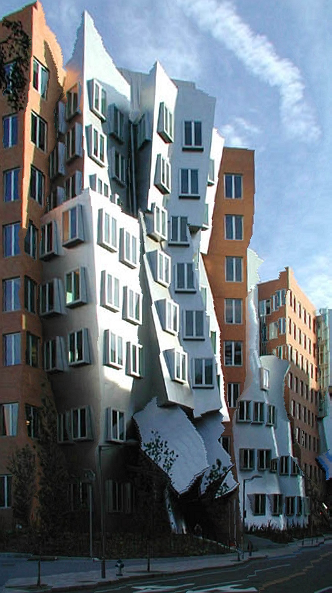

In [23]:
@manipulate for i=1:length(A)
    A[i]
end

2x2 Array{Int64,2}:
 1  0
 0  1